In [72]:
import torch

In [73]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [74]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                         download=True, transform=transform)

train_size = int(0.9 * len(train_set))
val_size = len(train_set) - train_size

train_subset, val_subset = random_split(train_set, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=4, shuffle=True, num_workers=1)

val_loader = DataLoader(val_subset, batch_size=4, shuffle=True, num_workers=1)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

test_loader = DataLoader(test_set, batch_size=4, shuffle=False, num_workers=1)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [75]:
print('Train set size:', len(train_subset))
print('Validation set size:', len(val_subset))
print('Test set size:', len(test_set))

Train set size: 45000
Validation set size: 5000
Test set size: 10000


In [76]:
import matplotlib.pyplot as plt
import numpy as np

dataiter = iter(train_loader)

Batch of images has shape: torch.Size([4, 3, 32, 32])


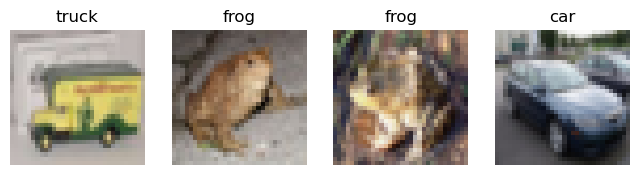

In [77]:
images, labels = next(dataiter)

print('Batch of images has shape:', images.shape)

def imshow(img, labels):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    fig, ax = plt.subplots(1, len(labels), figsize=(8, 2))
    for i in range(len(labels)):
        ax[i].imshow(np.transpose(npimg[i], (1, 2, 0)))
        ax[i].set_title(classes[labels[i]])
        ax[i].axis('off')
    plt.show()

imshow(images, labels)

In [78]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # 3 inputy, 6 outputow, 5x5 kernel
        self.pool = nn.AvgPool2d(2, 2)  # 2x2 pooling, stride 2
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        return x
    

In [79]:
net = Net().to(device)

In [80]:
from torchviz import make_dot
from IPython.display import Image, display

def computational_graph(model):
    inputs = torch.randn(1, 3, 32, 32).to(device)
    outputs = model(inputs)
    target = torch.tensor([1], dtype=torch.long).to(device)
    criterion = nn.CrossEntropyLoss()
    loss = criterion(outputs, target)
    loss.backward()
    dot = make_dot(outputs, params=dict(net.named_parameters()))
    dot.render("computation_graph", format="png")
    display(Image(filename="computation_graph.png"))

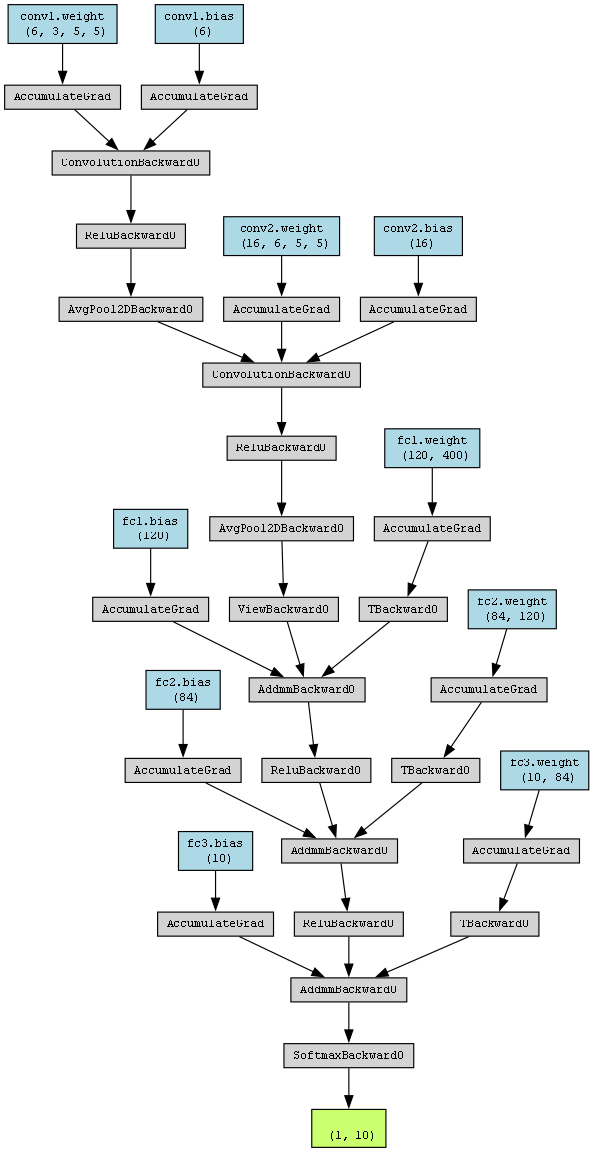

In [81]:
computational_graph(net)

In [84]:
sum(p.numel() for p in net.parameters())

62006

Pytorch używa Kaiming Uniform zwanym też He initialization zarówna dla nn.Conv2d jak i nn.Linear

In [85]:
# for name, param in net.named_parameters():
#     print(f'Layer: {name} | Initial Weights: \n{param.data}\n')

# 6

In [86]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [87]:
import matplotlib.pyplot as plt

def calculate_loss(net, data_loader, criterion, device):
    net.eval()
    total_loss = 0.0
    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    net.train()
    return total_loss / len(data_loader)

def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Iterations (in thousands)')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()
    
    
def test_accuracy(net, image_loader, device, df_type = "test"):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in image_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f'Accuracy of the network on the {df_type} images: {accuracy:.2f}%')
    return accuracy

In [88]:
train_losses = []
val_losses = []

[1, 2000] loss: 2.1031
Epoch 1, Validation Loss: 2.0983
[1, 4000] loss: 2.1056
Epoch 1, Validation Loss: 2.1067
[1, 6000] loss: 2.0901
Epoch 1, Validation Loss: 2.0931
[1, 8000] loss: 2.1039
Epoch 1, Validation Loss: 2.1053
[1, 10000] loss: 2.1123
Epoch 1, Validation Loss: 2.1274
[2, 2000] loss: 2.1369
Epoch 2, Validation Loss: 2.2106
[2, 4000] loss: 2.1707
Epoch 2, Validation Loss: 2.1338
[2, 6000] loss: 2.1526
Epoch 2, Validation Loss: 2.1193
[2, 8000] loss: 2.1580
Epoch 2, Validation Loss: 2.1548
[2, 10000] loss: 2.1378
Epoch 2, Validation Loss: 2.1303
Finished Training


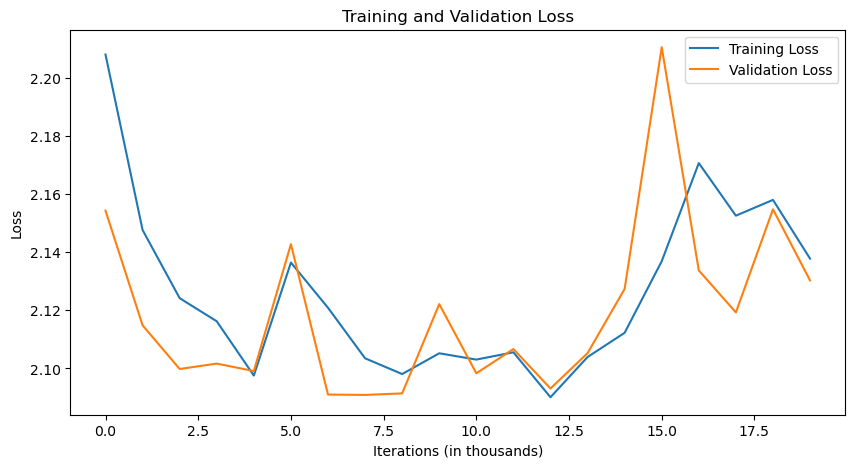

In [90]:
for epoch in range(2):
    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            avg_running_loss = running_loss / 2000
            train_losses.append(avg_running_loss)
            print(f'[{epoch + 1}, {i + 1}] loss: {avg_running_loss:.4f}')
            running_loss = 0.0

            val_loss = calculate_loss(net, val_loader, criterion, device)
            val_losses.append(val_loss)
            print(f'Epoch {epoch + 1}, Validation Loss: {val_loss:.4f}')
            
print('Finished Training')

plot_losses(train_losses, val_losses)

In [54]:
test_accuracy(net, train_loader, device, "train")
test_accuracy(net, test_loader, device, "test")

Accuracy of the network on the train images: 40.53%
Accuracy of the network on the test images: 40.47%


40.47

In [16]:
testdataiter = iter(test_loader)

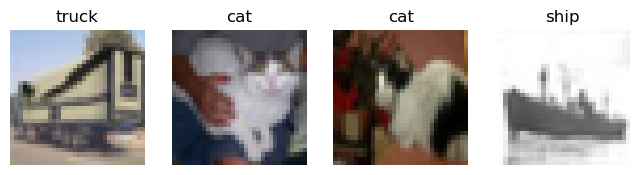

GroundTruth: truck cat cat ship
Predicted: truck cat dog ship


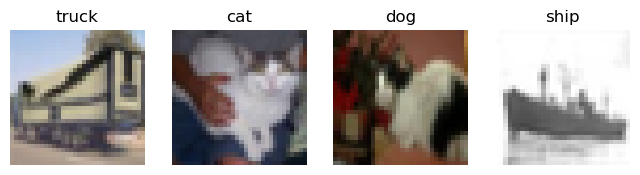

In [39]:
#test it
images, labels = next(testdataiter)

imshow(images, labels)
print('GroundTruth:', ' '.join(f'{classes[labels[j]]}' for j in range(4)))

images, labels = images.to(device), labels.to(device)

outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted:', ' '.join(f'{classes[predicted[j]]}' for j in range(4)))

imshow(images.cpu(), predicted)